In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

import argparse, torch, random
import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F

import tqdm 
from tqdm import tqdm
from snntorch import spikegen
import matplotlib.pyplot as plt
# from models import SNN, SpikeCELoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class WrapperFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, params, forward, backward):
        ctx.backward = backward
        pack, output = forward(input)
        ctx.save_for_backward(*pack)
        return output

    @staticmethod
    def backward(ctx, grad_output): # return gradient
        backward = ctx.backward
        pack     = ctx.saved_tensors
        grad_input, grad_weight = backward(grad_output, *pack)
        return grad_input, grad_weight, None, None

class FirstSpikeTime(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):   
        idx = torch.arange(input.shape[2], 0, -1).unsqueeze(0).unsqueeze(0).float().to(device)
        first_spike_times = torch.argmax(idx*input, dim=2).float()
        ctx.save_for_backward(input, first_spike_times.clone())
        first_spike_times[first_spike_times==0] = input.shape[2]-1
        return first_spike_times
    
    @staticmethod
    def backward(ctx, grad_output):
        input, first_spike_times = ctx.saved_tensors
        k = F.one_hot(first_spike_times.long(), input.shape[2]).float()
        grad_input = k * grad_output.unsqueeze(-1)
        return grad_input

In [4]:
'''  
    Input ->  [Batch, 784, 20] [Batch, ] : Current (cur)
    V     ->  [Batch, 10, 20] [Batch, ] : Voltage
    tau_m ->  [Batch, 10, 20] : Membrane Time Constant
    tau_s ->  [Batch, 10, 20] : Synaptic Time Constant
    spikes -> sending Threshold [128, 10]
    output -> [Batch, 10, 20]
    current -> Can refer to input
'''

class SpikingLinear(nn.Module):
    def __init__(self, input_dim, output_dim, T, dt, tau_m, tau_s, mu):
        super(SpikingLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.T  = T
        self.dt = dt
        self.tau_m  = tau_m
        self.tau_s  = tau_s
        
        self.weight = nn.Parameter(torch.Tensor(output_dim, input_dim)) # [10, 784]
        nn.init.normal_(self.weight, mu, mu)
        
        # self.forward = lambda input : WrapperFunction.apply(input, self.weight, self.manual_forward, self.manual_backward)
        
    def manual_forward(self, input):
        steps = int(self.T / self.dt)
    
        V      = torch.zeros(input.shape[0], self.output_dim, steps).to(device)
        I      = torch.zeros(input.shape[0], self.output_dim, steps).to(device)
        output = torch.zeros(input.shape[0], self.output_dim, steps).to(device)

        while True:
            for i in range(1, steps):
                t = i * self.dt
                V[:,:,i] = (1 - self.dt / self.tau_m) * V[:,:,i-1] + (self.dt / self.tau_m) * I[:,:,i-1] 
                I[:,:,i] = (1 - self.dt / self.tau_s) * I[:,:,i-1] + F.linear(input[:,:,i-1].float(), self.weight) # Linear trans WX
                
                spikes   = (V[:,:,i] > 1.0).float()
     
                output[:,:,i] = spikes
                # print(output.shape)
                V[:,:,i] = (1-spikes) * V[:,:,i]

            """
            Add small values (1e-1) for silent neurons ensuring a more robust and active network.
            self.training : Checks training state
            is_silent = output.sum(2).min(0)[0] == 0 # Checks if there are no silent neurons.
            """
            if self.training: 
                is_silent = output.sum(2).min(0)[0] == 0 
                self.weight.data[is_silent] = self.weight.data[is_silent] + 1e-1
                if is_silent.sum() == 0:
                    break
            else:
                break

        return (input, I, output), output
    
    def manual_backward(self, grad_output, input, I, post_spikes):
        steps = int(self.T / self.dt)
                
        lambda_V = torch.zeros(input.shape[0], self.output_dim, steps).to(device)
        lambda_I = torch.zeros(input.shape[0], self.output_dim, steps).to(device)
        
        grad_input  = torch.zeros(input.shape[0], input.shape[1], steps).to(device)
        grad_weight = torch.zeros(input.shape[0], * self.weight.shape).to(device)
        
        for i in range(steps-2, -1, -1): # go backwards from (steps-2) to 0
            t            = i * self.dt
            delta        = (lambda_V[:,:,i+1] - lambda_I[:,:,i+1])
            grad_input[:,:,i] = F.linear(delta, self.weight.t())
            lambda_V[:,:,i]   = (1 - self.dt / self.tau_m) * lambda_V[:,:,i+1] + post_spikes[:,:,i+1] * (lambda_V[:,:,i+1] + grad_output[:,:,i+1]) / (I[:,:,i] - 1 + 1e-10)
            lambda_I[:,:,i]   = lambda_I[:,:,i+1] + (self.dt / self.tau_s) * (lambda_V[:,:,i+1] - lambda_I[:,:,i+1])
            spike_bool        = input[:,:,i].float()
            grad_weight      -= (spike_bool.unsqueeze(1) * lambda_I[:,:,i].unsqueeze(2))
        
        return grad_input, grad_weight
    
    def forward(self, input):
        '''
        WrapperFunction.apply to make use of autograd system it triggers the execution of forward and backward system
        self.manual_forward, self.manual_backward are called here!
        '''
        return WrapperFunction.apply(input, self.weight, self.manual_forward, self.manual_backward)

In [5]:
class SNN(nn.Module):
    def __init__(self, input_dim, output_dim, T, dt, tau_m, tau_s):
        super(SNN, self).__init__()
        self.slinear1 = SpikingLinear(input_dim, 256, T, dt, tau_m, tau_s, 0.1) # 0.1 mu
        self.slinear2 = SpikingLinear(256, 10, T, dt, tau_m, tau_s, 0.1) # 0.1 mu
        self.outact   = FirstSpikeTime.apply # Why we need outact? but it returns first_spike_times I think it's similar to softmax to produce results
        
    def forward(self, input):     
        u = self.slinear1(input)  # [Batch, 784, 20] -> [Batch, 256, 20]
        u = self.slinear2(u)      # [Batch, 256, 20] -> [Batch, 10, 20]
        u = self.outact(u)        # [128, 10]
        
        return u
        
class SpikeCELoss(nn.Module):
    def __init__(self, T, xi, tau_s):
        super(SpikeCELoss, self).__init__()
        self.xi    = xi
        self.tau_s = tau_s
        self.celoss = nn.CrossEntropyLoss()
        
    def forward(self, input, target):
        loss = self.celoss(-input / (self.xi * self.tau_s), target)
        return loss

In [6]:
data_folder = "data" 
print_freq = 100
epochs = 20
lr = 1
batch_size = 512
xi = 0.4
alpha = 0.01
beta = 2
T = 50 # 20
dt = 1
tau_m = 20.0
tau_s = 5.0
t_max = 12.0
t_min = 2.0

def Latency_Coding(data): # Data [Batch, Channel, Width, Height] 
    spike_data = t_min + (t_max - t_min) * (data < 0.5).view(data.shape[0], -1)
    spike_data = F.one_hot(spike_data.long(), int(T))
    
    return spike_data

In [7]:
def train(model, criterion, optimizer, loader):
    total_correct = 0.
    total_loss = 0.
    total_samples = 0.

    model.train()
    for batch_idx, (input, target) in tqdm(enumerate(loader)):
        # input = spikegen.latency(input, num_steps=T, tau=20, threshold=0.01, 
        #                          clip=True, normalize=True, linear=True)
        
        # input = torch.permute(input, (1, 2, 3, 4, 0))
        # input = input.view(input.shape[0], input.shape[2]*input.shape[3], input.shape[4])
       
        input, target = Latency_Coding(input).to(device), target.to(device)
        # input, target = input.to(device), target.to(device)
        
        total_correct = 0.
        total_loss    = 0.
        total_samples = 0.
        
        output = model(input) ### Shape [128, 10]
        loss = criterion(output, target)
    
        predictions    = output.detach().min(1, keepdim=True)[1] # [128, 1] select index of the lowest element 

        ## Element-wise comparison with .eq/ correct labels counts
        total_correct += predictions.eq(target.detach().view_as(predictions)).sum().item()
        total_loss    += loss.item() * len(target)
        total_samples += len(target)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        if batch_idx % print_freq == 0:
            print('\tBatch {:03d}/{:03d}: \tAcc {:.2f}  Loss {:.3f}'.format(batch_idx, len(loader), 100*total_correct/total_samples, total_loss/total_samples))

    print('\t\tTrain: \tAcc {:.2f}  Loss {:.3f}'.format(100*total_correct/total_samples, total_loss/total_samples))
    
    return model


def test(model, criterion, loader):
    total_correct = 0.
    total_samples = 0.
    total_test_loss = 0.
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            # spike_data = spikegen.latency(data, num_steps=T, tau=20, threshold=0.01, 
            #                      clip=True, normalize=True, linear=True)
            
            # spike_data = torch.permute(spike_data, (1, 2, 3, 4, 0))
            
            # spike_data = spike_data.view(spike_data.shape[0], spike_data.shape[2]*spike_data.shape[3], spike_data.shape[4])
            
            spike_data, target = Latency_Coding(data).to(device), target.to(device)

            # spike_data, target = spike_data.to(device), target.to(device)
            
            first_post_spikes = model(spike_data)
            test_loss   = criterion(first_post_spikes, target)

            predictions = first_post_spikes.data.min(1, keepdim=True)[1]
            total_correct   += predictions.eq(target.data.view_as(predictions)).sum().item()
            total_test_loss += test_loss.item() * len(target)
            total_samples += len(target)
        
        Test_Loss = total_test_loss/total_samples
        Test_Accuracy = 100*total_correct/total_samples    
        
        print('\t\tTest: \tAcc {:.2f}  Loss {:.3f}'.format(100*total_correct/total_samples, total_test_loss/total_samples))

    return Test_Loss, Test_Accuracy

In [8]:
from torchvision import datasets, transforms

transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

train_dataset = datasets.MNIST('/tmp/data/mnist', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('/tmp/data/mnist', train=False, download=True, transform=transform)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
model = SNN(784, 10, T, dt, tau_m, tau_s).to(device)
criterion = SpikeCELoss(T, xi, tau_s)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), 
                             eps=1e-08)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

Loss = []
Accuracy = []
for epoch in tqdm(range(epochs)) :
    model = train(model, criterion, optimizer, train_loader)
    Test_Loss, Test_Accuracy = test(model, criterion, test_loader)

    Loss.append(Test_Loss)
    Accuracy.append(Test_Accuracy)
    
    print('Epoch {:03d}/{:03d}'.format(epoch, epochs))

    scheduler.step()

  0%|          | 0/20 [00:00<?, ?it/s]

	Batch 000/118: 	Acc 12.50  Loss 2.301


	Batch 100/118: 	Acc 69.92  Loss 0.884


118it [02:17,  1.17s/it]


		Train: 	Acc 77.08  Loss 0.782


  5%|▌         | 1/20 [02:23<45:34, 143.90s/it]

		Test: 	Acc 81.93  Loss 0.711
Epoch 000/020


	Batch 000/118: 	Acc 72.66  Loss 0.994


	Batch 100/118: 	Acc 88.87  Loss 0.452


118it [02:16,  1.16s/it]


		Train: 	Acc 79.17  Loss 0.595


 10%|█         | 2/20 [04:49<43:24, 144.68s/it]

		Test: 	Acc 81.91  Loss 0.616
Epoch 001/020


	Batch 000/118: 	Acc 79.69  Loss 0.678


	Batch 100/118: 	Acc 79.88  Loss 0.616


118it [02:12,  1.12s/it]


		Train: 	Acc 90.62  Loss 0.432


 15%|█▌        | 3/20 [07:08<40:20, 142.38s/it]

		Test: 	Acc 88.38  Loss 0.431
Epoch 002/020


	Batch 000/118: 	Acc 89.45  Loss 0.415


	Batch 100/118: 	Acc 78.71  Loss 0.650


118it [02:09,  1.09s/it]


		Train: 	Acc 89.58  Loss 0.455


 20%|██        | 4/20 [09:24<37:17, 139.87s/it]

		Test: 	Acc 90.05  Loss 0.392
Epoch 003/020


	Batch 000/118: 	Acc 90.82  Loss 0.391


	Batch 100/118: 	Acc 81.84  Loss 0.636


118it [02:12,  1.13s/it]


		Train: 	Acc 87.50  Loss 0.433


 25%|██▌       | 5/20 [11:44<34:57, 139.85s/it]

		Test: 	Acc 89.40  Loss 0.403
Epoch 004/020


	Batch 000/118: 	Acc 87.11  Loss 0.480


	Batch 100/118: 	Acc 90.43  Loss 0.402


118it [02:08,  1.09s/it]


		Train: 	Acc 91.67  Loss 0.429


 30%|███       | 6/20 [14:00<32:18, 138.49s/it]

		Test: 	Acc 87.64  Loss 0.446
Epoch 005/020


	Batch 000/118: 	Acc 85.74  Loss 0.483


	Batch 100/118: 	Acc 88.28  Loss 0.425


118it [02:14,  1.14s/it]


		Train: 	Acc 77.08  Loss 0.633


 35%|███▌      | 7/20 [16:22<30:16, 139.73s/it]

		Test: 	Acc 76.61  Loss 0.594
Epoch 006/020


	Batch 000/118: 	Acc 78.91  Loss 0.633


	Batch 100/118: 	Acc 87.89  Loss 0.364


118it [02:02,  1.03s/it]


		Train: 	Acc 88.54  Loss 0.422


 40%|████      | 8/20 [18:29<27:08, 135.75s/it]

		Test: 	Acc 89.03  Loss 0.399
Epoch 007/020


	Batch 000/118: 	Acc 88.09  Loss 0.410


	Batch 100/118: 	Acc 89.84  Loss 0.351


118it [01:51,  1.06it/s]


		Train: 	Acc 96.88  Loss 0.173


 45%|████▌     | 9/20 [20:26<23:48, 129.88s/it]

		Test: 	Acc 89.49  Loss 0.392
Epoch 008/020


	Batch 000/118: 	Acc 89.65  Loss 0.373


	Batch 100/118: 	Acc 85.55  Loss 0.429


118it [01:59,  1.01s/it]


		Train: 	Acc 77.08  Loss 0.619


 50%|█████     | 10/20 [22:31<21:23, 128.32s/it]

		Test: 	Acc 79.22  Loss 0.717
Epoch 009/020


	Batch 000/118: 	Acc 80.47  Loss 0.709


	Batch 100/118: 	Acc 90.23  Loss 0.379


118it [01:52,  1.05it/s]


		Train: 	Acc 76.04  Loss 0.692


 55%|█████▌    | 11/20 [24:28<18:43, 124.88s/it]

		Test: 	Acc 78.33  Loss 0.645
Epoch 010/020


	Batch 000/118: 	Acc 80.27  Loss 0.614


	Batch 100/118: 	Acc 84.96  Loss 0.449


118it [02:00,  1.03s/it]


		Train: 	Acc 88.54  Loss 0.478


 60%|██████    | 12/20 [26:36<16:45, 125.71s/it]

		Test: 	Acc 89.43  Loss 0.379
Epoch 011/020


	Batch 000/118: 	Acc 89.26  Loss 0.378


	Batch 100/118: 	Acc 92.97  Loss 0.334


118it [01:58,  1.00s/it]


		Train: 	Acc 89.58  Loss 0.397


 65%|██████▌   | 13/20 [28:40<14:37, 125.35s/it]

		Test: 	Acc 89.03  Loss 0.394
Epoch 012/020


	Batch 000/118: 	Acc 88.87  Loss 0.405


	Batch 100/118: 	Acc 88.87  Loss 0.404


118it [02:00,  1.02s/it]


		Train: 	Acc 88.54  Loss 0.390


 70%|███████   | 14/20 [30:46<12:32, 125.49s/it]

		Test: 	Acc 88.40  Loss 0.432
Epoch 013/020


	Batch 000/118: 	Acc 86.52  Loss 0.513


	Batch 100/118: 	Acc 89.06  Loss 0.362


118it [02:03,  1.05s/it]


		Train: 	Acc 94.79  Loss 0.236


 75%|███████▌  | 15/20 [32:56<10:34, 126.84s/it]

		Test: 	Acc 90.05  Loss 0.364
Epoch 014/020


	Batch 000/118: 	Acc 88.87  Loss 0.413


	Batch 100/118: 	Acc 90.43  Loss 0.366


118it [01:54,  1.03it/s]


		Train: 	Acc 93.75  Loss 0.245


 80%|████████  | 16/20 [34:57<08:20, 125.11s/it]

		Test: 	Acc 90.08  Loss 0.361
Epoch 015/020


	Batch 000/118: 	Acc 89.45  Loss 0.401


	Batch 100/118: 	Acc 88.28  Loss 0.432


118it [02:01,  1.03s/it]


		Train: 	Acc 79.17  Loss 0.802


 85%|████████▌ | 17/20 [37:04<06:16, 125.52s/it]

		Test: 	Acc 79.29  Loss 0.769
Epoch 016/020


	Batch 000/118: 	Acc 76.56  Loss 0.772


	Batch 100/118: 	Acc 91.99  Loss 0.321


118it [01:54,  1.03it/s]


		Train: 	Acc 91.67  Loss 0.258


 90%|█████████ | 18/20 [39:04<04:07, 123.95s/it]

		Test: 	Acc 90.19  Loss 0.358
Epoch 017/020


	Batch 000/118: 	Acc 91.80  Loss 0.303


	Batch 100/118: 	Acc 90.04  Loss 0.401


118it [02:00,  1.03s/it]


		Train: 	Acc 96.88  Loss 0.148


 95%|█████████▌| 19/20 [41:12<02:05, 125.05s/it]

		Test: 	Acc 90.14  Loss 0.353
Epoch 018/020


	Batch 000/118: 	Acc 91.60  Loss 0.309


	Batch 100/118: 	Acc 90.82  Loss 0.354


118it [02:02,  1.04s/it]


		Train: 	Acc 85.42  Loss 0.431


100%|██████████| 20/20 [43:20<00:00, 130.00s/it]

		Test: 	Acc 90.63  Loss 0.347
Epoch 019/020


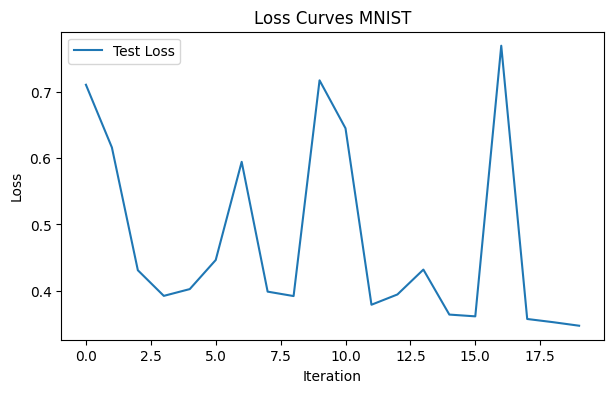

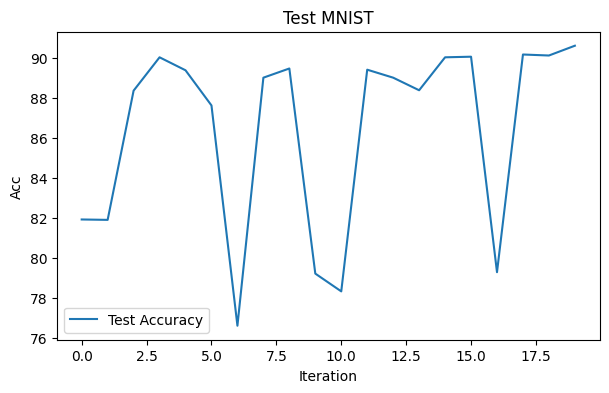

In [12]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(7, 4))
plt.plot(Loss)
plt.title("Loss Curves MNIST")
plt.legend(["Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

fig = plt.figure(facecolor="w", figsize=(7, 4))
plt.plot(Accuracy)
plt.title("Test MNIST")
plt.legend(["Test Accuracy"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()